In [121]:
import tensorflow as tf
tf.__version__
tf.config.experimental.enable_op_determinism()
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [122]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [123]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Tempo')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [124]:
def plot_correlation_matrix(df):
    correlation_matrix = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Matrix Heatmap")
    plt.show()

In [125]:
tf.keras.backend.clear_session()

In [126]:
subject = 'Sergipe - Consumo de Cimento (t)'
start_index = 0
split_index = 191 #Referente aos 230 anos de input 
window_size = 36
train_split = split_index + 1 - 30

In [127]:
data = pd.read_csv('2003_mo_model_input_SE.csv')
pd.set_option('display.max_columns', None)
data

,Unnamed: 0,Sergipe- custo m2 (R$),Sergipe - IDH Educacao,Sergipe - IDH,Sergipe - Depósito Poupança (R$),Sergipe - IDH Longevidade,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Sergipe - value,Sergipe - Produção de Cimento (t),Sergipe - Consumo de Cimento (t),Sergipe - PIB - Estadual,Sergipe - PIB - Construção Civil,Sergipe - PIB - Per Capita,Sergipe - PIB - Preços de Mercado,Sergipe - IDH Renda,Sergipe - Desemprego,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%)
0,2003-1,9513.254800,0.599319,0.669217,1.618045e+06,0.750379,1.154340,1013.090299,2716.496979,26.501337,23.889841,80.366597,3.552746,0.339447,152.791400,23.616,2.159732e+07,1.260978e+06,9.960678,2.029642e+07,0.648121,8.389943,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498
1,2003-2,9606.199031,0.599716,0.669542,1.622416e+06,0.750793,1.155152,1013.092341,2716.496979,26.502125,23.879336,80.334711,3.551254,0.341257,151.964054,21.357,2.162153e+07,1.262134e+06,9.961956,2.030238e+07,0.648377,8.384067,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389
2,2003-3,9693.715697,0.600113,0.669868,1.626787e+06,0.751207,1.155625,1013.093533,2716.496979,26.502585,23.873208,80.316112,3.550384,0.343016,154.467758,20.059,2.164574e+07,1.263289e+06,9.963234,2.030833e+07,0.648633,8.378190,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184
3,2003-4,9777.797840,0.600511,0.670193,1.631158e+06,0.751620,1.155676,1013.093660,2716.496979,26.502635,23.872551,80.314119,3.550291,0.344722,155.913400,19.920,2.166995e+07,1.264444e+06,9.964512,2.031429e+07,0.648889,8.372313,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287
4,2003-5,9852.699220,0.600908,0.670519,1.635529e+06,0.752034,1.195157,1012.797543,2575.798720,26.636934,23.787977,79.846291,3.554977,0.346174,157.467159,19.962,2.169416e+07,1.265599e+06,9.965790,2.032025e+07,0.649145,8.366437,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2023-5,33548.705040,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
245,2023-6,33497.662935,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
246,2023-7,33431.682561,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
247,2023-8,33345.640179,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


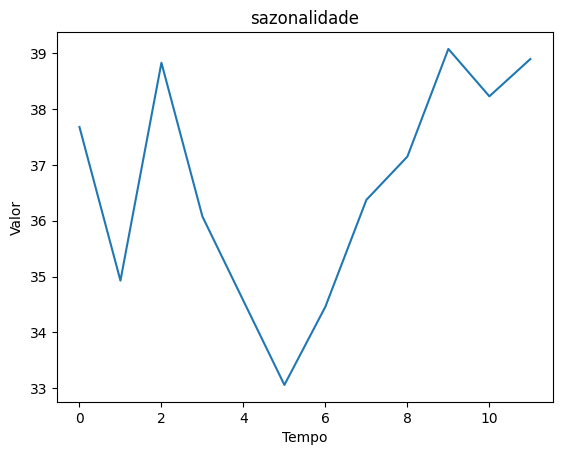

,sazonalidade
sazonalidade,
0,37.680295
1,34.927623
2,38.830336
3,36.075924
4,34.565679
5,33.058726
6,34.460511
7,36.374133
8,37.149163


In [128]:
def calculate_monthly_means(consume_of_cement, subject):
    df = pd.DataFrame({subject: consume_of_cement[:train_split]})
    df['sazonalidade'] = df.index % 12
    monthly_means = df.groupby('sazonalidade')[subject].mean()
    result_df = pd.DataFrame({'sazonalidade': monthly_means})

    return result_df

media_df = calculate_monthly_means(data[subject], subject)
plot_columns(media_df)
media_df

In [129]:
def fill_original_df_with_monthly_means(df_og, media_df):
    monthly_means = media_df['sazonalidade'].tolist()
    df_og['sazonalidade'] = [monthly_means[i % 12] for i in range(len(df_og))]
    return df_og

data = fill_original_df_with_monthly_means(data, media_df)
data = data[[col for col in data.columns if col != subject] + [subject]] #Seta consumo (target) para a coluna final
data

,Unnamed: 0,Sergipe- custo m2 (R$),Sergipe - IDH Educacao,Sergipe - IDH,Sergipe - Depósito Poupança (R$),Sergipe - IDH Longevidade,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Sergipe - value,Sergipe - Produção de Cimento (t),Sergipe - PIB - Estadual,Sergipe - PIB - Construção Civil,Sergipe - PIB - Per Capita,Sergipe - PIB - Preços de Mercado,Sergipe - IDH Renda,Sergipe - Desemprego,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),sazonalidade,Sergipe - Consumo de Cimento (t)
0,2003-1,9513.254800,0.599319,0.669217,1.618045e+06,0.750379,1.154340,1013.090299,2716.496979,26.501337,23.889841,80.366597,3.552746,0.339447,152.791400,2.159732e+07,1.260978e+06,9.960678,2.029642e+07,0.648121,8.389943,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498,37.680295,23.616
1,2003-2,9606.199031,0.599716,0.669542,1.622416e+06,0.750793,1.155152,1013.092341,2716.496979,26.502125,23.879336,80.334711,3.551254,0.341257,151.964054,2.162153e+07,1.262134e+06,9.961956,2.030238e+07,0.648377,8.384067,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389,34.927623,21.357
2,2003-3,9693.715697,0.600113,0.669868,1.626787e+06,0.751207,1.155625,1013.093533,2716.496979,26.502585,23.873208,80.316112,3.550384,0.343016,154.467758,2.164574e+07,1.263289e+06,9.963234,2.030833e+07,0.648633,8.378190,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184,38.830336,20.059
3,2003-4,9777.797840,0.600511,0.670193,1.631158e+06,0.751620,1.155676,1013.093660,2716.496979,26.502635,23.872551,80.314119,3.550291,0.344722,155.913400,2.166995e+07,1.264444e+06,9.964512,2.031429e+07,0.648889,8.372313,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287,36.075924,19.920
4,2003-5,9852.699220,0.600908,0.670519,1.635529e+06,0.752034,1.195157,1012.797543,2575.798720,26.636934,23.787977,79.846291,3.554977,0.346174,157.467159,2.169416e+07,1.265599e+06,9.965790,2.032025e+07,0.649145,8.366437,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538,34.565679,19.962
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2023-5,33548.705040,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.565679,NaN
245,2023-6,33497.662935,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33.058726,NaN
246,2023-7,33431.682561,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.460511,NaN
247,2023-8,33345.640179,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36.374133,NaN


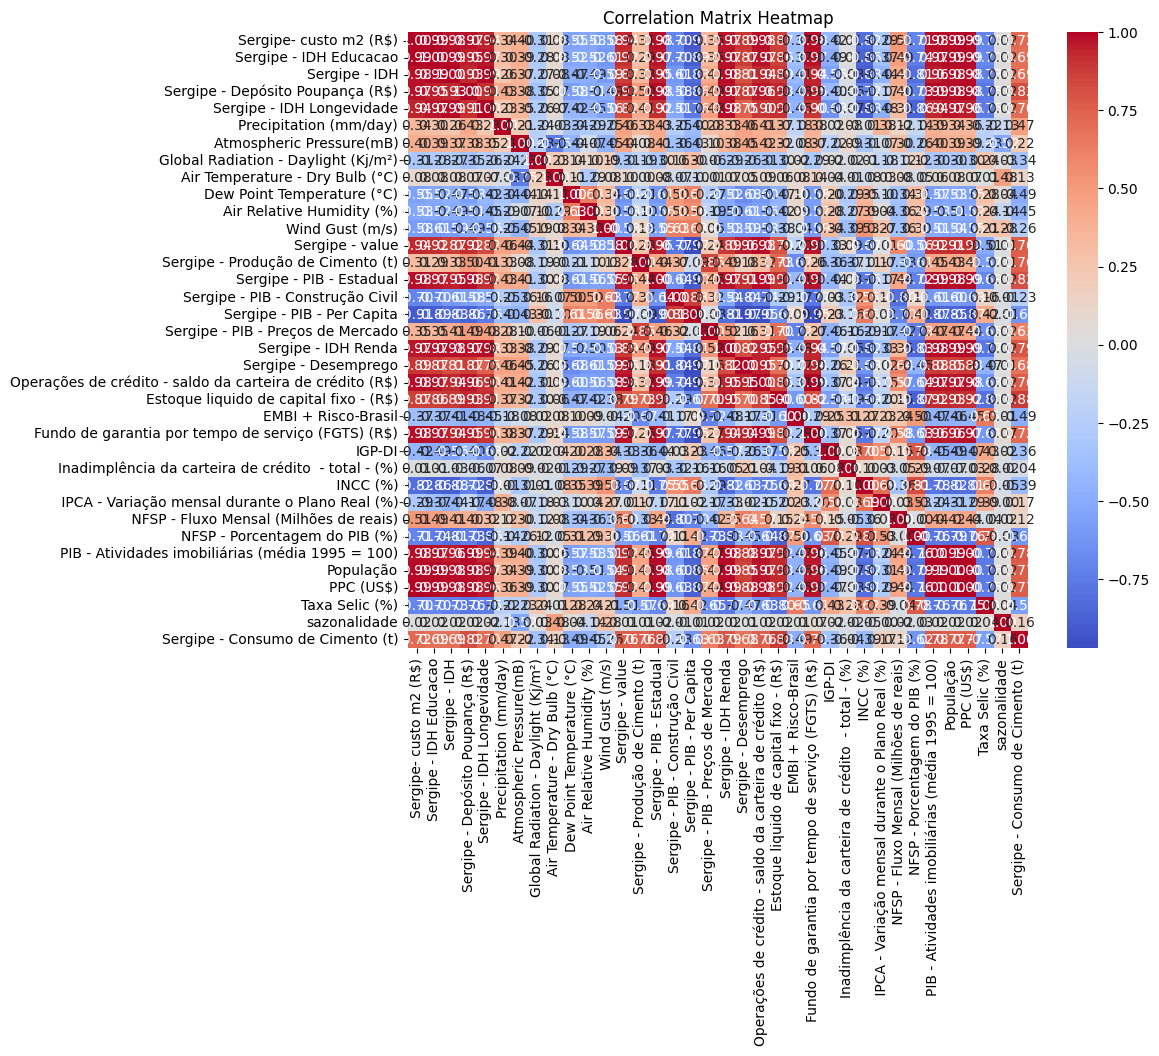

In [130]:
plot_data = data.iloc[:split_index + 1,1:]
plot_correlation_matrix(plot_data)

In [131]:
data =data.drop(['Air Temperature - Dry Bulb (°C)', 
                 'Wind Gust (m/s)',
                 'Global Radiation - Daylight (Kj/m²)'], axis=1)
data

,Unnamed: 0,Sergipe- custo m2 (R$),Sergipe - IDH Educacao,Sergipe - IDH,Sergipe - Depósito Poupança (R$),Sergipe - IDH Longevidade,Precipitation (mm/day),Atmospheric Pressure(mB),Dew Point Temperature (°C),Air Relative Humidity (%),Sergipe - value,Sergipe - Produção de Cimento (t),Sergipe - PIB - Estadual,Sergipe - PIB - Construção Civil,Sergipe - PIB - Per Capita,Sergipe - PIB - Preços de Mercado,Sergipe - IDH Renda,Sergipe - Desemprego,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),sazonalidade,Sergipe - Consumo de Cimento (t)
0,2003-1,9513.254800,0.599319,0.669217,1.618045e+06,0.750379,1.154340,1013.090299,23.889841,80.366597,0.339447,152.791400,2.159732e+07,1.260978e+06,9.960678,2.029642e+07,0.648121,8.389943,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498,37.680295,23.616
1,2003-2,9606.199031,0.599716,0.669542,1.622416e+06,0.750793,1.155152,1013.092341,23.879336,80.334711,0.341257,151.964054,2.162153e+07,1.262134e+06,9.961956,2.030238e+07,0.648377,8.384067,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389,34.927623,21.357
2,2003-3,9693.715697,0.600113,0.669868,1.626787e+06,0.751207,1.155625,1013.093533,23.873208,80.316112,0.343016,154.467758,2.164574e+07,1.263289e+06,9.963234,2.030833e+07,0.648633,8.378190,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184,38.830336,20.059
3,2003-4,9777.797840,0.600511,0.670193,1.631158e+06,0.751620,1.155676,1013.093660,23.872551,80.314119,0.344722,155.913400,2.166995e+07,1.264444e+06,9.964512,2.031429e+07,0.648889,8.372313,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287,36.075924,19.920
4,2003-5,9852.699220,0.600908,0.670519,1.635529e+06,0.752034,1.195157,1012.797543,23.787977,79.846291,0.346174,157.467159,2.169416e+07,1.265599e+06,9.965790,2.032025e+07,0.649145,8.366437,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538,34.565679,19.962
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2023-5,33548.705040,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.565679,NaN
245,2023-6,33497.662935,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33.058726,NaN
246,2023-7,33431.682561,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.460511,NaN
247,2023-8,33345.640179,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36.374133,NaN


In [132]:
input_data = data.iloc[:split_index + 1,1:-1]
mean = np.mean(input_data, axis=0)
stddev =  np.std(input_data, axis=0)
input_data = ((input_data - mean) /stddev)
# scaler=MinMaxScaler()
# scaled_data = scaler.fit_transform(input_data)
# input_data = pd.DataFrame(scaled_data, columns=input_data.columns)
input_data

,Sergipe- custo m2 (R$),Sergipe - IDH Educacao,Sergipe - IDH,Sergipe - Depósito Poupança (R$),Sergipe - IDH Longevidade,Precipitation (mm/day),Atmospheric Pressure(mB),Dew Point Temperature (°C),Air Relative Humidity (%),Sergipe - value,Sergipe - Produção de Cimento (t),Sergipe - PIB - Estadual,Sergipe - PIB - Construção Civil,Sergipe - PIB - Per Capita,Sergipe - PIB - Preços de Mercado,Sergipe - IDH Renda,Sergipe - Desemprego,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),sazonalidade
0,-1.680353,-1.869665,-2.191597,-1.614494,-2.460918,-0.548085,-0.493535,1.048294,0.984037,-1.329544,-1.638248,-1.769739,-0.221258,0.566843,-2.721827,-2.221701,-0.858763,-1.361787,-2.389042,-0.582420,-1.347324,3.890153,1.258423,3.122582,2.723741,0.364808,4.398348,-1.873379,-2.042341,-1.825286,2.132459,0.553102
1,-1.658121,-1.845295,-2.153964,-1.608624,-2.412668,-0.546183,-0.491902,1.044155,0.980200,-1.294452,-1.660220,-1.748579,-0.190897,0.585366,-2.626858,-2.186667,-0.861105,-1.361224,-2.352139,-0.799075,-1.380245,3.551840,1.252755,2.970356,2.350880,0.368956,4.222509,-1.868164,-2.014760,-1.813648,1.592202,-0.870107
2,-1.637187,-1.820925,-2.116331,-1.602754,-2.364418,-0.545073,-0.490950,1.041741,0.977962,-1.260345,-1.593729,-1.727419,-0.160535,0.603889,-2.531890,-2.151633,-0.863447,-1.361187,-2.315236,-0.618584,-1.392954,3.391423,1.251338,2.869895,2.123016,0.331110,4.026019,-1.862949,-1.987179,-1.801637,2.999926,1.147706
3,-1.617074,-1.796556,-2.078698,-1.596885,-2.316168,-0.544954,-0.490848,1.041482,0.977722,-1.227259,-1.555337,-1.706259,-0.130173,0.622411,-2.436921,-2.116599,-0.865789,-1.360756,-2.278333,-0.139520,-1.396056,3.135979,1.249134,2.773628,2.021477,0.244570,3.811492,-1.857734,-1.959598,-1.789347,1.273293,-0.276403
4,-1.599158,-1.772186,-2.041065,-1.591015,-2.267919,-0.452431,-0.727528,1.008162,0.921429,-1.199102,-1.514074,-1.685099,-0.099812,0.640934,-2.341953,-2.081566,-0.868132,-1.359394,-2.241431,0.494336,-1.388786,2.955412,1.238186,2.977624,1.887113,0.279013,3.567576,-1.851305,-1.932017,-1.777381,2.045407,-1.057242
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,1.607863,1.505378,1.375707,1.252417,1.100593,-0.680585,1.085592,-0.787513,-0.794757,0.926582,-1.147300,1.088440,-1.830495,-1.273118,-0.375044,1.082408,1.205390,1.316363,0.389193,-0.244459,1.237409,0.589021,-0.685819,-1.749976,-2.010387,2.953658,-0.572934,1.406756,1.365911,1.413217,-1.311366,-0.122220
188,1.627825,1.502882,1.367460,1.261207,1.083744,-0.703466,0.572047,-0.689721,-0.831530,0.922177,-1.137939,1.080037,-1.823605,-1.263526,-0.370593,1.084643,1.201393,1.330590,0.370392,-0.199028,1.214214,1.043728,-0.770458,-1.593005,-1.870713,3.351323,-0.588777,1.428132,1.376610,1.425045,-1.417143,0.278492
189,1.651636,1.500386,1.359213,1.269997,1.066895,-0.740767,0.287615,-0.598683,-0.900168,0.923529,-1.097718,1.071634,-1.816716,-1.253934,-0.366142,1.086878,1.197396,1.352241,0.351592,-0.173807,1.409043,1.387010,-0.910077,-1.351489,-1.806230,3.404908,-0.612606,1.449507,1.387308,1.436067,-1.597784,1.275773
190,1.676932,1.497890,1.350966,1.278786,1.050046,-0.620199,-0.037242,-0.468197,-0.922448,0.936477,-1.086004,1.063231,-1.809827,-1.244342,-0.361691,1.089113,1.193399,1.370978,0.332791,-0.169867,1.654237,1.815728,-1.020687,-1.198492,-1.727496,3.671303,-0.640956,1.463901,1.398006,1.446142,-1.400787,0.836882


In [133]:
# Shift para prever futuro e não presente
target_data = data[subject].shift(-12)
target_data

0      19.642
1      17.778
2      21.180
3      18.824
4      16.535
        ...  
244       NaN
245       NaN
246       NaN
247       NaN
248       NaN
Name: Sergipe - Consumo de Cimento (t), Length: 249, dtype: float64

In [134]:
# input para treinamento
train_input = input_data.iloc[start_index:train_split]
train_input

,Sergipe- custo m2 (R$),Sergipe - IDH Educacao,Sergipe - IDH,Sergipe - Depósito Poupança (R$),Sergipe - IDH Longevidade,Precipitation (mm/day),Atmospheric Pressure(mB),Dew Point Temperature (°C),Air Relative Humidity (%),Sergipe - value,Sergipe - Produção de Cimento (t),Sergipe - PIB - Estadual,Sergipe - PIB - Construção Civil,Sergipe - PIB - Per Capita,Sergipe - PIB - Preços de Mercado,Sergipe - IDH Renda,Sergipe - Desemprego,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),sazonalidade
0,-1.680353,-1.869665,-2.191597,-1.614494,-2.460918,-0.548085,-0.493535,1.048294,0.984037,-1.329544,-1.638248,-1.769739,-0.221258,0.566843,-2.721827,-2.221701,-0.858763,-1.361787,-2.389042,-0.582420,-1.347324,3.890153,1.258423,3.122582,2.723741,0.364808,4.398348,-1.873379,-2.042341,-1.825286,2.132459,0.553102
1,-1.658121,-1.845295,-2.153964,-1.608624,-2.412668,-0.546183,-0.491902,1.044155,0.980200,-1.294452,-1.660220,-1.748579,-0.190897,0.585366,-2.626858,-2.186667,-0.861105,-1.361224,-2.352139,-0.799075,-1.380245,3.551840,1.252755,2.970356,2.350880,0.368956,4.222509,-1.868164,-2.014760,-1.813648,1.592202,-0.870107
2,-1.637187,-1.820925,-2.116331,-1.602754,-2.364418,-0.545073,-0.490950,1.041741,0.977962,-1.260345,-1.593729,-1.727419,-0.160535,0.603889,-2.531890,-2.151633,-0.863447,-1.361187,-2.315236,-0.618584,-1.392954,3.391423,1.251338,2.869895,2.123016,0.331110,4.026019,-1.862949,-1.987179,-1.801637,2.999926,1.147706
3,-1.617074,-1.796556,-2.078698,-1.596885,-2.316168,-0.544954,-0.490848,1.041482,0.977722,-1.227259,-1.555337,-1.706259,-0.130173,0.622411,-2.436921,-2.116599,-0.865789,-1.360756,-2.278333,-0.139520,-1.396056,3.135979,1.249134,2.773628,2.021477,0.244570,3.811492,-1.857734,-1.959598,-1.789347,1.273293,-0.276403
4,-1.599158,-1.772186,-2.041065,-1.591015,-2.267919,-0.452431,-0.727528,1.008162,0.921429,-1.199102,-1.514074,-1.685099,-0.099812,0.640934,-2.341953,-2.081566,-0.868132,-1.359394,-2.241431,0.494336,-1.388786,2.955412,1.238186,2.977624,1.887113,0.279013,3.567576,-1.851305,-1.932017,-1.777381,2.045407,-1.057242
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157,1.117730,1.310245,1.387754,0.805959,1.452440,0.009032,0.045232,-0.383585,-0.969536,1.521513,-0.132792,1.143453,-1.270245,-1.549275,-0.543399,1.262926,1.342411,1.335787,0.819304,0.961603,1.338424,-1.233012,0.749349,-0.883659,-0.214006,1.216560,-0.607704,0.952667,1.031384,1.044043,0.043807,-0.870107
158,1.134837,1.322310,1.390522,0.818322,1.444491,0.129672,0.442509,-0.409807,-0.892104,1.498482,-0.189562,1.147046,-1.306762,-1.539477,-0.525912,1.256332,1.335629,1.325546,0.808136,1.030624,1.300351,-1.299304,0.977327,-0.950771,-0.434717,1.155373,-0.620523,0.954843,1.042716,1.056960,0.210856,1.147706
159,1.152132,1.334376,1.393291,0.830686,1.436542,0.203960,0.938373,-0.549218,-0.868043,1.475235,-0.253067,1.150639,-1.343278,-1.529680,-0.508425,1.249739,1.328848,1.315396,0.796969,1.039183,1.250508,-1.248662,1.048267,-1.028465,-0.524091,1.056140,-0.631530,0.957019,1.054049,1.070172,0.107070,-0.276403
160,1.166159,1.346441,1.396059,0.843050,1.428593,0.503234,1.548347,-0.700311,-0.824927,1.452580,-0.330172,1.154232,-1.379795,-1.519882,-0.490938,1.243145,1.322066,1.306664,0.785801,1.017171,1.240363,-1.068274,1.048868,-1.103668,-0.614500,1.147619,-0.640320,0.956331,1.065381,1.083626,0.392942,-1.057242


In [135]:
# Alvo para treinamento
train_target = target_data.iloc[start_index:train_split]
train_target

0      19.642
1      17.778
2      21.180
3      18.824
4      16.535
        ...  
157    37.579
158    48.016
159    38.263
160    40.413
161    34.053
Name: Sergipe - Consumo de Cimento (t), Length: 162, dtype: float64

In [136]:
def create_batches(t_input, t_target, window_size, start_from):
    
    X_batches = []
    y_batches = []

    train_input_values = t_input.values 

    for i in range(len(t_input) - window_size):
        
        X_window = train_input_values[i:i+window_size, :]
        y_target = t_target[start_from+i+window_size]

        X_batches.append(X_window)
        y_batches.append(y_target)

    return np.array(X_batches), np.array(y_batches)

In [137]:
reshaped_train, reshaped_target = create_batches(train_input, 
                                                 train_target, 
                                                 window_size, 
                                                 start_index)
reshaped_train.shape

(126, 36, 32)

In [138]:
# input para treinamento
test_input = input_data.iloc[train_split - window_size:split_index + 1]
test_input

,Sergipe- custo m2 (R$),Sergipe - IDH Educacao,Sergipe - IDH,Sergipe - Depósito Poupança (R$),Sergipe - IDH Longevidade,Precipitation (mm/day),Atmospheric Pressure(mB),Dew Point Temperature (°C),Air Relative Humidity (%),Sergipe - value,Sergipe - Produção de Cimento (t),Sergipe - PIB - Estadual,Sergipe - PIB - Construção Civil,Sergipe - PIB - Per Capita,Sergipe - PIB - Preços de Mercado,Sergipe - IDH Renda,Sergipe - Desemprego,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),sazonalidade
126,0.516865,0.451980,0.374606,1.034841,0.346760,1.895509,1.315363,-0.242958,0.188587,0.708889,1.481103,0.853614,-0.111030,-0.618059,1.032015,0.756937,0.905037,0.722924,0.944085,-0.882533,0.551812,-0.368821,-0.155884,0.045243,0.888984,-0.230612,-0.460555,0.913820,0.651397,0.697312,-1.048761,-1.111617
127,0.535630,0.467997,0.381094,1.061242,0.343226,1.706520,0.984885,-0.170554,0.209644,0.753914,1.474131,0.869229,-0.156897,-0.659078,0.974979,0.748630,0.923945,0.745258,0.947319,-0.815413,0.566622,-0.328087,-0.349984,0.061828,0.954254,-0.156322,-0.440372,0.923198,0.664707,0.706933,-0.649312,-0.122220
128,0.555334,0.484014,0.387582,1.087644,0.339692,3.153518,0.487571,0.090714,0.358234,0.799633,1.440003,0.884845,-0.202764,-0.700096,0.917944,0.740322,0.942853,0.767990,0.950553,-0.745839,0.568617,-0.176031,-0.529294,0.046225,1.045217,-0.120008,-0.419247,0.932576,0.678017,0.715675,-0.535369,0.278492
129,0.574927,0.500031,0.394069,1.114046,0.336157,3.157052,0.061679,0.159843,0.366846,0.849863,1.408120,0.900461,-0.248632,-0.741114,0.860908,0.732015,0.961762,0.799035,0.953786,-0.687348,0.719776,-0.113037,-0.788101,0.032522,1.176395,-0.143194,-0.397019,0.941953,0.691327,0.723490,-1.288807,1.275773
130,0.594445,0.516048,0.400557,1.140448,0.332623,2.755431,-0.414626,0.329438,0.484169,0.896706,1.375556,0.916077,-0.294499,-0.782133,0.803873,0.723707,0.980670,0.830824,0.957020,-0.639220,0.905478,-0.022703,-1.020394,0.042757,1.303259,-0.028712,-0.376532,0.942711,0.704637,0.730579,-1.507550,0.836882
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,1.607863,1.505378,1.375707,1.252417,1.100593,-0.680585,1.085592,-0.787513,-0.794757,0.926582,-1.147300,1.088440,-1.830495,-1.273118,-0.375044,1.082408,1.205390,1.316363,0.389193,-0.244459,1.237409,0.589021,-0.685819,-1.749976,-2.010387,2.953658,-0.572934,1.406756,1.365911,1.413217,-1.311366,-0.122220
188,1.627825,1.502882,1.367460,1.261207,1.083744,-0.703466,0.572047,-0.689721,-0.831530,0.922177,-1.137939,1.080037,-1.823605,-1.263526,-0.370593,1.084643,1.201393,1.330590,0.370392,-0.199028,1.214214,1.043728,-0.770458,-1.593005,-1.870713,3.351323,-0.588777,1.428132,1.376610,1.425045,-1.417143,0.278492
189,1.651636,1.500386,1.359213,1.269997,1.066895,-0.740767,0.287615,-0.598683,-0.900168,0.923529,-1.097718,1.071634,-1.816716,-1.253934,-0.366142,1.086878,1.197396,1.352241,0.351592,-0.173807,1.409043,1.387010,-0.910077,-1.351489,-1.806230,3.404908,-0.612606,1.449507,1.387308,1.436067,-1.597784,1.275773
190,1.676932,1.497890,1.350966,1.278786,1.050046,-0.620199,-0.037242,-0.468197,-0.922448,0.936477,-1.086004,1.063231,-1.809827,-1.244342,-0.361691,1.089113,1.193399,1.370978,0.332791,-0.169867,1.654237,1.815728,-1.020687,-1.198492,-1.727496,3.671303,-0.640956,1.463901,1.398006,1.446142,-1.400787,0.836882


In [139]:
reshaped_test, reshaped_test_target = create_batches(test_input, 
                                                     target_data, 
                                                     window_size, 
                                                     train_split - window_size)
reshaped_test.shape 

(30, 36, 32)

In [140]:
def validation_splitter(arr, div_factor, add_factor=0):
    split_factor = len(arr) // div_factor
    positions_to_drop_index = []
    positions_to_drop = []
    for i in range(split_factor):
        pos = len(arr) - (i * div_factor + 1)
        positions_to_drop_index.append(pos)
        positions_to_drop.append(pos + add_factor)
    
    arr_droped = arr[positions_to_drop]
    arr_result = np.delete(arr, positions_to_drop_index, axis=0)
    
    return arr_result, arr_droped

In [156]:
# Rede Neural Recorrente com optmizador Estocástico
def lstm_model(train_input, train_target, want_verbose=1, seed=0):
    if seed != 0:
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)
    # Aṕos 500 epochs sem grandes melhoras no val_loss, interrompe.
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                      patience=500, 
                                                      verbose=want_verbose, 
                                                      restore_best_weights=True,
                                                      start_from_epoch=500)
    train, train_val = validation_splitter(train_input, 7)
    target,target_val = validation_splitter(train_target, 7)
#     display(train.shape)
#     display(train_val.shape)
#     display(target.shape)
#     display(target_val.shape)
    # Método estocástico e learning rate=0.005
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.005)
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(36, activation='tanh', 
                             return_sequences=True, 
                             input_shape=(reshaped_train.shape[1],
                                          reshaped_train.shape[2])),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.LSTM(180,activation='tanh'),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer=optimizer, loss='mean_squared_error')   
    history = model.fit(train, 
                        target, 
                        epochs=10000,
                        validation_data=(train_val,
                                         target_val),
                        callbacks=[early_stopping], 
                        verbose=want_verbose)
    return model, history

In [157]:
def get_a_good_seed(train_input, train_target, test_input, test_target):

    random_seeds = [random.randint(0, 2**32 - 1) for _ in range(5)]
    print(random_seeds)

    best_loss = float('inf')
    winner_seed = None
    i = 0
    for seed in random_seeds:
        print(f"\n\nStep: {i} ___________________________________________")
        i += 1

        model, history = lstm_model(train_input, train_target, want_verbose=0, seed=seed)
        current_loss = min(history.history['val_loss'][500:])
        print(f"val_loss: {current_loss}")

        if current_loss < best_loss:
            best_loss = current_loss
            winner_seed = seed
            print(f"winner_seed: {winner_seed}")
            if winner_seed == 0.0:
                return winner_seed

    return winner_seed

In [158]:
winner_seed = get_a_good_seed(reshaped_train, reshaped_target, reshaped_test, reshaped_test_target)
print(f"\n\nfinal_seed: {winner_seed}")

[2309630764, 1263030742, 2378486043, 281984409, 1202284898]


Step: 0 ___________________________________________
val_loss: 11.75454330444336
winner_seed: 2309630764


Step: 1 ___________________________________________
val_loss: 11.033147811889648
winner_seed: 1263030742


Step: 2 ___________________________________________
val_loss: 8.917353630065918
winner_seed: 2378486043


Step: 3 ___________________________________________
val_loss: 9.705286026000977


Step: 4 ___________________________________________
val_loss: 11.044544219970703


final_seed: 2378486043


In [160]:
trained_model, history = lstm_model(reshaped_train, 
                                    reshaped_target, 
                                    want_verbose=1, 
                                    seed=winner_seed)

Epoch 1/10000
4/4 [==============================] - 2s 113ms/step - loss: 1486.3479 - val_loss: 187.2569
Epoch 2/10000
4/4 [==============================] - 0s 8ms/step - loss: 106.2173 - val_loss: 81.0414
Epoch 3/10000
4/4 [==============================] - 0s 8ms/step - loss: 73.1403 - val_loss: 58.0855
Epoch 4/10000
4/4 [==============================] - 0s 8ms/step - loss: 94.9019 - val_loss: 77.4174
Epoch 5/10000
4/4 [==============================] - 0s 8ms/step - loss: 94.9248 - val_loss: 97.4875
Epoch 6/10000
4/4 [==============================] - 0s 8ms/step - loss: 117.9332 - val_loss: 92.8693
Epoch 7/10000
4/4 [==============================] - 0s 8ms/step - loss: 883.5042 - val_loss: 75.2305
Epoch 8/10000
4/4 [==============================] - 0s 8ms/step - loss: 69.5602 - val_loss: 109.0094
Epoch 9/10000
4/4 [==============================] - 0s 8ms/step - loss: 94.2483 - val_loss: 53.1673
Epoch 10/10000
4/4 [==============================] - 0s 8ms/step - loss: 40.5990 

4/4 [==============================] - 0s 8ms/step - loss: 12.7882 - val_loss: 27.3803
Epoch 82/10000
4/4 [==============================] - 0s 8ms/step - loss: 15.8213 - val_loss: 18.9281
Epoch 83/10000
4/4 [==============================] - 0s 8ms/step - loss: 10.6034 - val_loss: 19.1315
Epoch 84/10000
4/4 [==============================] - 0s 8ms/step - loss: 12.9738 - val_loss: 18.3114
Epoch 85/10000
4/4 [==============================] - 0s 8ms/step - loss: 11.0837 - val_loss: 17.9435
Epoch 86/10000
4/4 [==============================] - 0s 8ms/step - loss: 11.3033 - val_loss: 22.2534
Epoch 87/10000
4/4 [==============================] - 0s 8ms/step - loss: 14.1966 - val_loss: 18.7331
Epoch 88/10000
4/4 [==============================] - 0s 8ms/step - loss: 10.4555 - val_loss: 17.4890
Epoch 89/10000
4/4 [==============================] - 0s 8ms/step - loss: 10.5593 - val_loss: 16.5401
Epoch 90/10000
4/4 [==============================] - 0s 8ms/step - loss: 10.7090 - val_loss: 25.

4/4 [==============================] - 0s 8ms/step - loss: 8.5829 - val_loss: 17.4128
Epoch 162/10000
4/4 [==============================] - 0s 8ms/step - loss: 8.9101 - val_loss: 15.2896
Epoch 163/10000
4/4 [==============================] - 0s 8ms/step - loss: 8.9926 - val_loss: 19.0180
Epoch 164/10000
4/4 [==============================] - 0s 8ms/step - loss: 9.6808 - val_loss: 18.0480
Epoch 165/10000
4/4 [==============================] - 0s 8ms/step - loss: 9.1677 - val_loss: 15.1686
Epoch 166/10000
4/4 [==============================] - 0s 8ms/step - loss: 9.2393 - val_loss: 15.3186
Epoch 167/10000
4/4 [==============================] - 0s 8ms/step - loss: 9.6329 - val_loss: 27.2709
Epoch 168/10000
4/4 [==============================] - 0s 8ms/step - loss: 9.5316 - val_loss: 15.6519
Epoch 169/10000
4/4 [==============================] - 0s 8ms/step - loss: 8.7687 - val_loss: 15.7326
Epoch 170/10000
4/4 [==============================] - 0s 8ms/step - loss: 9.0714 - val_loss: 16.0

4/4 [==============================] - 0s 8ms/step - loss: 7.6266 - val_loss: 16.4142
Epoch 242/10000
4/4 [==============================] - 0s 7ms/step - loss: 7.7686 - val_loss: 16.8467
Epoch 243/10000
4/4 [==============================] - 0s 8ms/step - loss: 9.5080 - val_loss: 16.3408
Epoch 244/10000
4/4 [==============================] - 0s 8ms/step - loss: 8.4626 - val_loss: 18.4564
Epoch 245/10000
4/4 [==============================] - 0s 8ms/step - loss: 9.3701 - val_loss: 14.3260
Epoch 246/10000
4/4 [==============================] - 0s 8ms/step - loss: 7.3370 - val_loss: 25.4451
Epoch 247/10000
4/4 [==============================] - 0s 8ms/step - loss: 13.0944 - val_loss: 16.1987
Epoch 248/10000
4/4 [==============================] - 0s 8ms/step - loss: 8.3089 - val_loss: 12.4853
Epoch 249/10000
4/4 [==============================] - 0s 8ms/step - loss: 7.9554 - val_loss: 17.1753
Epoch 250/10000
4/4 [==============================] - 0s 8ms/step - loss: 9.0245 - val_loss: 13.

4/4 [==============================] - 0s 8ms/step - loss: 8.6939 - val_loss: 16.3890
Epoch 322/10000
4/4 [==============================] - 0s 8ms/step - loss: 6.8366 - val_loss: 15.3154
Epoch 323/10000
4/4 [==============================] - 0s 8ms/step - loss: 8.6971 - val_loss: 15.1166
Epoch 324/10000
4/4 [==============================] - 0s 8ms/step - loss: 7.6882 - val_loss: 16.1151
Epoch 325/10000
4/4 [==============================] - 0s 7ms/step - loss: 8.1186 - val_loss: 17.5969
Epoch 326/10000
4/4 [==============================] - 0s 8ms/step - loss: 7.1736 - val_loss: 15.7347
Epoch 327/10000
4/4 [==============================] - 0s 8ms/step - loss: 7.8976 - val_loss: 16.7539
Epoch 328/10000
4/4 [==============================] - 0s 7ms/step - loss: 7.7556 - val_loss: 16.0893
Epoch 329/10000
4/4 [==============================] - 0s 8ms/step - loss: 6.7347 - val_loss: 15.8138
Epoch 330/10000
4/4 [==============================] - 0s 8ms/step - loss: 7.8156 - val_loss: 14.5

4/4 [==============================] - 0s 7ms/step - loss: 6.8351 - val_loss: 15.3547
Epoch 402/10000
4/4 [==============================] - 0s 8ms/step - loss: 8.1900 - val_loss: 13.7764
Epoch 403/10000
4/4 [==============================] - 0s 7ms/step - loss: 7.0972 - val_loss: 14.6032
Epoch 404/10000
4/4 [==============================] - 0s 8ms/step - loss: 8.2041 - val_loss: 14.7453
Epoch 405/10000
4/4 [==============================] - 0s 8ms/step - loss: 6.0985 - val_loss: 13.6658
Epoch 406/10000
4/4 [==============================] - 0s 8ms/step - loss: 6.4219 - val_loss: 14.7324
Epoch 407/10000
4/4 [==============================] - 0s 8ms/step - loss: 8.9569 - val_loss: 14.0586
Epoch 408/10000
4/4 [==============================] - 0s 8ms/step - loss: 8.7134 - val_loss: 15.3292
Epoch 409/10000
4/4 [==============================] - 0s 8ms/step - loss: 7.0164 - val_loss: 15.4849
Epoch 410/10000
4/4 [==============================] - 0s 8ms/step - loss: 6.8437 - val_loss: 15.6

4/4 [==============================] - 0s 8ms/step - loss: 7.6168 - val_loss: 13.4629
Epoch 482/10000
4/4 [==============================] - 0s 8ms/step - loss: 6.3806 - val_loss: 15.2597
Epoch 483/10000
4/4 [==============================] - 0s 7ms/step - loss: 6.0517 - val_loss: 17.2855
Epoch 484/10000
4/4 [==============================] - 0s 8ms/step - loss: 7.1506 - val_loss: 14.8511
Epoch 485/10000
4/4 [==============================] - 0s 8ms/step - loss: 7.2563 - val_loss: 16.1678
Epoch 486/10000
4/4 [==============================] - 0s 7ms/step - loss: 6.4075 - val_loss: 15.8572
Epoch 487/10000
4/4 [==============================] - 0s 8ms/step - loss: 6.7095 - val_loss: 14.1757
Epoch 488/10000
4/4 [==============================] - 0s 8ms/step - loss: 6.2160 - val_loss: 17.4244
Epoch 489/10000
4/4 [==============================] - 0s 8ms/step - loss: 8.0421 - val_loss: 15.0136
Epoch 490/10000
4/4 [==============================] - 0s 8ms/step - loss: 6.9498 - val_loss: 14.2

4/4 [==============================] - 0s 8ms/step - loss: 5.7263 - val_loss: 13.7134
Epoch 562/10000
4/4 [==============================] - 0s 8ms/step - loss: 6.8244 - val_loss: 14.6013
Epoch 563/10000
4/4 [==============================] - 0s 7ms/step - loss: 6.3635 - val_loss: 13.4753
Epoch 564/10000
4/4 [==============================] - 0s 8ms/step - loss: 7.1677 - val_loss: 14.6732
Epoch 565/10000
4/4 [==============================] - 0s 8ms/step - loss: 7.6019 - val_loss: 17.4517
Epoch 566/10000
4/4 [==============================] - 0s 8ms/step - loss: 6.5183 - val_loss: 16.6415
Epoch 567/10000
4/4 [==============================] - 0s 8ms/step - loss: 7.4578 - val_loss: 15.6671
Epoch 568/10000
4/4 [==============================] - 0s 8ms/step - loss: 6.0980 - val_loss: 14.1646
Epoch 569/10000
4/4 [==============================] - 0s 8ms/step - loss: 5.7199 - val_loss: 13.4983
Epoch 570/10000
4/4 [==============================] - 0s 8ms/step - loss: 6.2316 - val_loss: 13.8

4/4 [==============================] - 0s 8ms/step - loss: 5.6347 - val_loss: 14.4519
Epoch 642/10000
4/4 [==============================] - 0s 8ms/step - loss: 5.7664 - val_loss: 13.8585
Epoch 643/10000
4/4 [==============================] - 0s 8ms/step - loss: 5.9513 - val_loss: 17.0168
Epoch 644/10000
4/4 [==============================] - 0s 8ms/step - loss: 7.1571 - val_loss: 15.6383
Epoch 645/10000
4/4 [==============================] - 0s 8ms/step - loss: 6.6107 - val_loss: 16.7096
Epoch 646/10000
4/4 [==============================] - 0s 8ms/step - loss: 6.4228 - val_loss: 24.2127
Epoch 647/10000
4/4 [==============================] - 0s 8ms/step - loss: 9.0418 - val_loss: 14.0823
Epoch 648/10000
4/4 [==============================] - 0s 8ms/step - loss: 6.1362 - val_loss: 12.8545
Epoch 649/10000
4/4 [==============================] - 0s 8ms/step - loss: 5.6773 - val_loss: 16.0566
Epoch 650/10000
4/4 [==============================] - 0s 8ms/step - loss: 5.8114 - val_loss: 15.1

4/4 [==============================] - 0s 8ms/step - loss: 5.9541 - val_loss: 13.7111
Epoch 722/10000
4/4 [==============================] - 0s 8ms/step - loss: 6.0121 - val_loss: 14.3126
Epoch 723/10000
4/4 [==============================] - 0s 7ms/step - loss: 6.1719 - val_loss: 16.9169
Epoch 724/10000
4/4 [==============================] - 0s 8ms/step - loss: 5.5387 - val_loss: 14.2280
Epoch 725/10000
4/4 [==============================] - 0s 8ms/step - loss: 5.1841 - val_loss: 18.3176
Epoch 726/10000
4/4 [==============================] - 0s 8ms/step - loss: 5.7343 - val_loss: 15.5767
Epoch 727/10000
4/4 [==============================] - 0s 8ms/step - loss: 5.7972 - val_loss: 13.3022
Epoch 728/10000
4/4 [==============================] - 0s 8ms/step - loss: 6.2670 - val_loss: 16.5327
Epoch 729/10000
4/4 [==============================] - 0s 7ms/step - loss: 5.4553 - val_loss: 13.9436
Epoch 730/10000
4/4 [==============================] - 0s 8ms/step - loss: 5.3535 - val_loss: 14.7

4/4 [==============================] - 0s 8ms/step - loss: 5.4242 - val_loss: 17.0120
Epoch 802/10000
4/4 [==============================] - 0s 8ms/step - loss: 5.3584 - val_loss: 12.7785
Epoch 803/10000
4/4 [==============================] - 0s 7ms/step - loss: 5.9756 - val_loss: 14.1547
Epoch 804/10000
4/4 [==============================] - 0s 8ms/step - loss: 6.0088 - val_loss: 13.5649
Epoch 805/10000
4/4 [==============================] - 0s 8ms/step - loss: 5.6504 - val_loss: 11.8986
Epoch 806/10000
4/4 [==============================] - 0s 7ms/step - loss: 5.4364 - val_loss: 12.7158
Epoch 807/10000
4/4 [==============================] - 0s 8ms/step - loss: 6.1698 - val_loss: 13.5127
Epoch 808/10000
4/4 [==============================] - 0s 8ms/step - loss: 4.9644 - val_loss: 12.3837
Epoch 809/10000
4/4 [==============================] - 0s 8ms/step - loss: 5.3625 - val_loss: 12.3140
Epoch 810/10000
4/4 [==============================] - 0s 8ms/step - loss: 5.1218 - val_loss: 18.6

4/4 [==============================] - 0s 8ms/step - loss: 4.5642 - val_loss: 14.0686
Epoch 882/10000
4/4 [==============================] - 0s 7ms/step - loss: 5.5160 - val_loss: 12.8183
Epoch 883/10000
4/4 [==============================] - 0s 7ms/step - loss: 5.1324 - val_loss: 15.5798
Epoch 884/10000
4/4 [==============================] - 0s 8ms/step - loss: 5.3449 - val_loss: 13.8235
Epoch 885/10000
4/4 [==============================] - 0s 7ms/step - loss: 5.9916 - val_loss: 12.7941
Epoch 886/10000
4/4 [==============================] - 0s 8ms/step - loss: 5.7153 - val_loss: 15.7818
Epoch 887/10000
4/4 [==============================] - 0s 8ms/step - loss: 5.7840 - val_loss: 12.9156
Epoch 888/10000
4/4 [==============================] - 0s 7ms/step - loss: 5.5546 - val_loss: 13.5361
Epoch 889/10000
4/4 [==============================] - 0s 8ms/step - loss: 5.8173 - val_loss: 13.2097
Epoch 890/10000
4/4 [==============================] - 0s 8ms/step - loss: 5.6529 - val_loss: 12.8

4/4 [==============================] - 0s 7ms/step - loss: 5.8375 - val_loss: 14.8715
Epoch 962/10000
4/4 [==============================] - 0s 8ms/step - loss: 5.2950 - val_loss: 20.1661
Epoch 963/10000
4/4 [==============================] - 0s 7ms/step - loss: 5.9088 - val_loss: 14.3802
Epoch 964/10000
4/4 [==============================] - 0s 8ms/step - loss: 5.6808 - val_loss: 17.7098
Epoch 965/10000
4/4 [==============================] - 0s 8ms/step - loss: 5.5267 - val_loss: 15.7418
Epoch 966/10000
4/4 [==============================] - 0s 8ms/step - loss: 5.7592 - val_loss: 19.6327
Epoch 967/10000
4/4 [==============================] - 0s 8ms/step - loss: 5.7630 - val_loss: 13.4918
Epoch 968/10000
4/4 [==============================] - 0s 8ms/step - loss: 5.2850 - val_loss: 14.9776
Epoch 969/10000
4/4 [==============================] - 0s 7ms/step - loss: 5.6010 - val_loss: 14.5613
Epoch 970/10000
4/4 [==============================] - 0s 8ms/step - loss: 4.7307 - val_loss: 15.3

4/4 [==============================] - 0s 8ms/step - loss: 4.7079 - val_loss: 12.5880
Epoch 1042/10000
4/4 [==============================] - 0s 8ms/step - loss: 5.3568 - val_loss: 12.2718
Epoch 1043/10000
4/4 [==============================] - 0s 8ms/step - loss: 5.0196 - val_loss: 12.6489
Epoch 1044/10000
4/4 [==============================] - 0s 8ms/step - loss: 5.9897 - val_loss: 14.4468
Epoch 1045/10000
4/4 [==============================] - 0s 8ms/step - loss: 6.1668 - val_loss: 17.2314
Epoch 1046/10000
4/4 [==============================] - 0s 7ms/step - loss: 5.6453 - val_loss: 14.6623
Epoch 1047/10000
4/4 [==============================] - 0s 8ms/step - loss: 4.7730 - val_loss: 13.8735
Epoch 1048/10000
4/4 [==============================] - 0s 7ms/step - loss: 5.0796 - val_loss: 13.9001
Epoch 1049/10000
4/4 [==============================] - 0s 8ms/step - loss: 4.8236 - val_loss: 13.4161
Epoch 1050/10000
4/4 [==============================] - 0s 8ms/step - loss: 5.2376 - val_l

4/4 [==============================] - 0s 8ms/step - loss: 5.5296 - val_loss: 11.0931
Epoch 1121/10000
4/4 [==============================] - 0s 8ms/step - loss: 5.5636 - val_loss: 10.8194
Epoch 1122/10000
4/4 [==============================] - 0s 8ms/step - loss: 4.7276 - val_loss: 11.5493
Epoch 1123/10000
4/4 [==============================] - 0s 8ms/step - loss: 5.1049 - val_loss: 10.7803
Epoch 1124/10000
4/4 [==============================] - 0s 7ms/step - loss: 4.5056 - val_loss: 12.8512
Epoch 1125/10000
4/4 [==============================] - 0s 8ms/step - loss: 5.8420 - val_loss: 11.5379
Epoch 1126/10000
4/4 [==============================] - 0s 7ms/step - loss: 6.1370 - val_loss: 12.6424
Epoch 1127/10000
4/4 [==============================] - 0s 8ms/step - loss: 4.7273 - val_loss: 12.4763
Epoch 1128/10000
4/4 [==============================] - 0s 8ms/step - loss: 4.6857 - val_loss: 13.8441
Epoch 1129/10000
4/4 [==============================] - 0s 7ms/step - loss: 5.1609 - val_l

4/4 [==============================] - 0s 8ms/step - loss: 4.5109 - val_loss: 11.3600
Epoch 1200/10000
4/4 [==============================] - 0s 8ms/step - loss: 5.2315 - val_loss: 11.4800
Epoch 1201/10000
4/4 [==============================] - 0s 8ms/step - loss: 6.0038 - val_loss: 11.4643
Epoch 1202/10000
4/4 [==============================] - 0s 8ms/step - loss: 5.1598 - val_loss: 14.7429
Epoch 1203/10000
4/4 [==============================] - 0s 8ms/step - loss: 5.0022 - val_loss: 16.1536
Epoch 1204/10000
4/4 [==============================] - 0s 8ms/step - loss: 4.7671 - val_loss: 12.2526
Epoch 1205/10000
4/4 [==============================] - 0s 8ms/step - loss: 5.2528 - val_loss: 14.2969
Epoch 1206/10000
4/4 [==============================] - 0s 7ms/step - loss: 5.2601 - val_loss: 12.8381
Epoch 1207/10000
4/4 [==============================] - 0s 8ms/step - loss: 4.8722 - val_loss: 13.6112
Epoch 1208/10000
4/4 [==============================] - 0s 7ms/step - loss: 5.0360 - val_l

4/4 [==============================] - 0s 8ms/step - loss: 5.5842 - val_loss: 13.3824
Epoch 1279/10000
4/4 [==============================] - 0s 7ms/step - loss: 4.5309 - val_loss: 11.7601
Epoch 1280/10000
4/4 [==============================] - 0s 8ms/step - loss: 5.0132 - val_loss: 12.0161
Epoch 1281/10000
4/4 [==============================] - 0s 8ms/step - loss: 5.0742 - val_loss: 14.0629
Epoch 1282/10000
4/4 [==============================] - 0s 7ms/step - loss: 4.8369 - val_loss: 17.1113
Epoch 1283/10000
4/4 [==============================] - 0s 8ms/step - loss: 5.5631 - val_loss: 11.5197
Epoch 1284/10000
4/4 [==============================] - 0s 8ms/step - loss: 5.0246 - val_loss: 12.3123
Epoch 1285/10000
4/4 [==============================] - 0s 7ms/step - loss: 5.5639 - val_loss: 10.7768
Epoch 1286/10000
4/4 [==============================] - 0s 8ms/step - loss: 5.1466 - val_loss: 10.7872
Epoch 1287/10000
4/4 [==============================] - 0s 8ms/step - loss: 5.3655 - val_l

4/4 [==============================] - 0s 8ms/step - loss: 4.6055 - val_loss: 14.0664
Epoch 1358/10000
4/4 [==============================] - 0s 8ms/step - loss: 4.5196 - val_loss: 10.9147
Epoch 1359/10000
4/4 [==============================] - 0s 7ms/step - loss: 4.8198 - val_loss: 11.0095
Epoch 1360/10000
4/4 [==============================] - 0s 8ms/step - loss: 4.1793 - val_loss: 12.8741
Epoch 1361/10000
4/4 [==============================] - 0s 8ms/step - loss: 4.7964 - val_loss: 12.1555
Epoch 1362/10000
4/4 [==============================] - 0s 7ms/step - loss: 5.1992 - val_loss: 11.6170
Epoch 1363/10000
4/4 [==============================] - 0s 8ms/step - loss: 4.8055 - val_loss: 12.3983
Epoch 1364/10000
4/4 [==============================] - 0s 8ms/step - loss: 4.8736 - val_loss: 16.3408
Epoch 1365/10000
4/4 [==============================] - 0s 7ms/step - loss: 4.5593 - val_loss: 12.4284
Epoch 1366/10000
4/4 [==============================] - 0s 8ms/step - loss: 4.9228 - val_l

Epoch 1437/10000
4/4 [==============================] - 0s 7ms/step - loss: 5.1790 - val_loss: 11.7749
Epoch 1438/10000
4/4 [==============================] - 0s 8ms/step - loss: 4.9383 - val_loss: 11.4683
Epoch 1439/10000
4/4 [==============================] - 0s 8ms/step - loss: 4.3816 - val_loss: 13.1465
Epoch 1440/10000
4/4 [==============================] - 0s 7ms/step - loss: 4.2768 - val_loss: 12.9618
Epoch 1441/10000
4/4 [==============================] - 0s 8ms/step - loss: 5.0374 - val_loss: 10.8725
Epoch 1442/10000
4/4 [==============================] - 0s 8ms/step - loss: 4.8122 - val_loss: 10.7166
Epoch 1443/10000
4/4 [==============================] - 0s 7ms/step - loss: 4.2686 - val_loss: 9.7714
Epoch 1444/10000
4/4 [==============================] - 0s 8ms/step - loss: 4.4588 - val_loss: 9.1303
Epoch 1445/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.9790 - val_loss: 9.1554
Epoch 1446/10000
4/4 [==============================] - 0s 7ms/step - loss: 

4/4 [==============================] - 0s 7ms/step - loss: 4.4342 - val_loss: 13.7942
Epoch 1517/10000
4/4 [==============================] - 0s 8ms/step - loss: 4.3340 - val_loss: 12.5684
Epoch 1518/10000
4/4 [==============================] - 0s 8ms/step - loss: 5.0935 - val_loss: 10.1678
Epoch 1519/10000
4/4 [==============================] - 0s 8ms/step - loss: 5.0414 - val_loss: 12.5025
Epoch 1520/10000
4/4 [==============================] - 0s 8ms/step - loss: 5.1370 - val_loss: 11.2883
Epoch 1521/10000
4/4 [==============================] - 0s 8ms/step - loss: 4.6258 - val_loss: 9.2370
Epoch 1522/10000
4/4 [==============================] - 0s 7ms/step - loss: 5.0304 - val_loss: 9.2663
Epoch 1523/10000
4/4 [==============================] - 0s 8ms/step - loss: 4.0566 - val_loss: 11.9045
Epoch 1524/10000
4/4 [==============================] - 0s 8ms/step - loss: 4.9196 - val_loss: 9.7144
Epoch 1525/10000
4/4 [==============================] - 0s 8ms/step - loss: 4.4314 - val_loss

Epoch 1596/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.9382 - val_loss: 9.9876
Epoch 1597/10000
4/4 [==============================] - 0s 8ms/step - loss: 4.3607 - val_loss: 10.5905
Epoch 1598/10000
4/4 [==============================] - 0s 7ms/step - loss: 4.8145 - val_loss: 9.1172
Epoch 1599/10000
4/4 [==============================] - 0s 8ms/step - loss: 5.1420 - val_loss: 10.2681
Epoch 1600/10000
4/4 [==============================] - 0s 8ms/step - loss: 4.5743 - val_loss: 10.2749
Epoch 1601/10000
4/4 [==============================] - 0s 7ms/step - loss: 4.3558 - val_loss: 13.1994
Epoch 1602/10000
4/4 [==============================] - 0s 8ms/step - loss: 4.9136 - val_loss: 11.5230
Epoch 1603/10000
4/4 [==============================] - 0s 8ms/step - loss: 4.6480 - val_loss: 12.3479
Epoch 1604/10000
4/4 [==============================] - 0s 8ms/step - loss: 4.5576 - val_loss: 9.7834
Epoch 1605/10000
4/4 [==============================] - 0s 8ms/step - loss: 

4/4 [==============================] - 0s 8ms/step - loss: 3.7118 - val_loss: 10.3669
Epoch 1676/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.6711 - val_loss: 10.7046
Epoch 1677/10000
4/4 [==============================] - 0s 8ms/step - loss: 4.0435 - val_loss: 11.3610
Epoch 1678/10000
4/4 [==============================] - 0s 8ms/step - loss: 4.5615 - val_loss: 12.2247
Epoch 1679/10000
4/4 [==============================] - 0s 8ms/step - loss: 4.4409 - val_loss: 11.0013
Epoch 1680/10000
4/4 [==============================] - 0s 8ms/step - loss: 4.2623 - val_loss: 11.1891
Epoch 1681/10000
4/4 [==============================] - 0s 8ms/step - loss: 4.6151 - val_loss: 11.0745
Epoch 1682/10000
4/4 [==============================] - 0s 8ms/step - loss: 4.7304 - val_loss: 11.6293
Epoch 1683/10000
4/4 [==============================] - 0s 8ms/step - loss: 4.4984 - val_loss: 11.6036
Epoch 1684/10000
4/4 [==============================] - 0s 8ms/step - loss: 4.6009 - val_l

Epoch 1755/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.8955 - val_loss: 10.3967
Epoch 1756/10000
4/4 [==============================] - 0s 7ms/step - loss: 4.1303 - val_loss: 15.0658
Epoch 1757/10000
4/4 [==============================] - 0s 8ms/step - loss: 4.8328 - val_loss: 12.0217
Epoch 1758/10000
4/4 [==============================] - 0s 8ms/step - loss: 4.3329 - val_loss: 10.0349
Epoch 1759/10000
4/4 [==============================] - 0s 7ms/step - loss: 4.5071 - val_loss: 10.3388
Epoch 1760/10000
4/4 [==============================] - 0s 8ms/step - loss: 4.3739 - val_loss: 10.5059
Epoch 1761/10000
4/4 [==============================] - 0s 8ms/step - loss: 4.9065 - val_loss: 10.8196
Epoch 1762/10000
4/4 [==============================] - 0s 7ms/step - loss: 4.0173 - val_loss: 12.6348
Epoch 1763/10000
4/4 [==============================] - 0s 8ms/step - loss: 4.8575 - val_loss: 11.8741
Epoch 1764/10000
4/4 [==============================] - 0s 8ms/step - los

4/4 [==============================] - 0s 8ms/step - loss: 3.9839 - val_loss: 10.0766
Epoch 1835/10000
4/4 [==============================] - 0s 8ms/step - loss: 4.6953 - val_loss: 11.1876
Epoch 1836/10000
4/4 [==============================] - 0s 7ms/step - loss: 4.1195 - val_loss: 10.5618
Epoch 1837/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.6532 - val_loss: 10.5486
Epoch 1838/10000
4/4 [==============================] - 0s 7ms/step - loss: 4.5361 - val_loss: 10.3330
Epoch 1839/10000
4/4 [==============================] - 0s 8ms/step - loss: 4.1437 - val_loss: 13.1522
Epoch 1840/10000
4/4 [==============================] - 0s 8ms/step - loss: 4.5445 - val_loss: 15.9112
Epoch 1841/10000
4/4 [==============================] - 0s 7ms/step - loss: 5.4142 - val_loss: 10.7045
Epoch 1842/10000
4/4 [==============================] - 0s 8ms/step - loss: 4.8004 - val_loss: 11.7708
Epoch 1843/10000
4/4 [==============================] - 0s 8ms/step - loss: 4.6370 - val_l

In [161]:
def mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    results_data = []

    for i in range(len(test_target)):
        prediction = model.predict(test_input[i:i+1])
        target = test_target[start_target + i]
        error = np.abs(prediction - target)
        errors.append(error)
        error_percent.append(error/target)
        results_data.append([f"Month-{i + 1}", 
                             prediction[0][0], 
                             target, 
                             error[0][0]])

    df_results = pd.DataFrame(results_data, columns=["Month", "Prediction", "Target", "Error"])

    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return df_results, mae, mape

In [162]:
df_results, mae, mape = mae_mape_calculator(trained_model, 
                                            reshaped_test, 
                                            reshaped_test_target, 
                                            start_index)
pd.set_option('display.max_columns', None)
df_results.T

1/1 [==============================] - 0s 14ms/step


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12,Month-13,Month-14,Month-15,Month-16,Month-17,Month-18,Month-19,Month-20,Month-21,Month-22,Month-23,Month-24,Month-25,Month-26,Month-27,Month-28,Month-29,Month-30
Prediction,38.73341,38.91264,38.592186,38.192902,37.722008,37.377266,37.138206,37.519928,38.228065,37.855507,37.630493,38.042587,33.274918,32.864178,32.621525,32.273891,31.787104,31.220034,30.877901,30.973969,31.635136,31.959732,32.653,33.363289,33.119564,33.209248,33.386375,33.460804,33.26889,33.311226
Target,36.174,38.394,35.688,42.076,39.875,38.984,41.652,33.904,29.447,29.197,26.297,29.209,28.158,31.132,30.195,31.537,30.748,30.734,36.567,30.849,31.021,31.437,31.533,26.431,25.978,29.86,39.045,45.213,42.237,39.732
Error,2.55941,0.518639,2.904186,3.883099,2.152992,1.606735,4.513794,3.615929,8.781065,8.658506,11.333492,8.833588,5.116917,1.732178,2.426525,0.736891,1.039104,0.486034,5.6891,0.124968,0.614136,0.522732,1.119999,6.932289,7.141563,3.349247,5.658623,11.752197,8.968109,6.420773


In [163]:
display(mae)
display(mape)

4.306427

0.13155754

In [164]:
def year_mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    
    target_sum = 0
    prediction_sum = 0
    
    for i in range(len(test_target)):
        if i % 12 == 0 and i != 0:
            error = np.abs(target_sum - prediction_sum)
            errors.append(error)
            error_percent.append(error / target_sum)
            print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
            target_sum = 0
            prediction_sum = 0
            
        prediction = model.predict(test_input[i:i+1])
        target_sum += test_target[start_target + i]
        prediction_sum += prediction
        
    error = np.abs(target_sum - prediction_sum)
    errors.append(error)
    error_percent.append(error / target_sum)
    print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
        
    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return errors, mae, mape

In [165]:
errors, mae, mape = year_mae_mape_calculator(trained_model,
                                             reshaped_test, 
                                             reshaped_test_target,
                                             start_index)
display(errors)
display(mae)
display(mape)

1/1 [==============================] - 0s 15ms/step
Ano-0: |Prediction[[455.9452]] - Target[420.89700000000005]| =  Error: [[35.048187]]; MAPE:[[0.08327022]]
1/1 [==============================] - 0s 14ms/step
Ano-0: |Prediction[[385.5047]] - Target[370.34200000000004]| =  Error: [[15.162689]]; MAPE:[[0.0409424]]
1/1 [==============================] - 0s 14ms/step
Ano-5: |Prediction[[199.7561]] - Target[222.065]| =  Error: [[22.308899]]; MAPE:[[0.10046112]]


[array([[35.048187]], dtype=float32),
 array([[15.162689]], dtype=float32),
 array([[22.308899]], dtype=float32)]

24.173258

0.07489125